#### Intro

In this note-book I built a very simple classifier for classifying violin and guitar samples. For demonstration purposes,
the data set used is only 120 samples. 50 guitar samples and 50 violin samples, and the rest for testing. This is a
very small dataset and therefore the model starts to over-fit very quickly. More dynamic model build systems will be
explored in the future.

Dataset source: [Philharmonia Data Set](https://philharmonia.co.uk/resources/sound-samples/)

A neat package called [kapre](https://github.com/keunwoochoi/kapre) was explored. This packaged has a number of custom
tensorflow.keras.layers.Layer objects for processing audio on the GPU as part of the model's architecture. In our case
we are computing the mel-spectrogram transform as if it were the first layer in our network. This means the input for
the network is just raw audio. This eliminated any pre-processing we would have had to do.

Package source: https://github.com/keunwoochoi/kapre

#### Load data from previous notebook

In [1]:
import pickle
import random
from typing import List, Tuple

import numpy as np
from kapre.composed import get_melspectrogram_layer
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import utils.constants as consts
from ai_tools.displays import display_optimal_epoch_and_metrics, plot_learning_metrics
from utils.helpers import Data

with open('../pickled-data/train_data.pickle', 'rb') as file_handler:  # Train data.
    train_data: List[Data] = pickle.load(file_handler)

with open('../pickled-data/test_data.pickle', 'rb') as file_handler:  # Test data.
    test_data: List[Data] = pickle.load(file_handler)

#### Build model.

In [2]:
def build_simple_cnn() -> Sequential:
    """
    :return: A compiled tensorflow.keras.Model ready for fitting.
    """

    # Shape: (num_samples, sample_rate, channels)
    input_shape: Tuple[int, int] = (consts.SAMPLE_RATE, 1)  # Mono audio so 1 channel.

    # First layer transforms raw audio into a mel-spectrogram in GPU.
    mel_layer: Sequential = get_melspectrogram_layer(
        input_shape=input_shape,
        n_fft=consts.NUM_FFT,
        hop_length=consts.MEL_HOP_LEN,
        sample_rate=consts.SAMPLE_RATE,
        return_decibel=True,
        input_data_format='channels_last',
        output_data_format='channels_last'
    )

    model = Sequential()

    # Mel transformation.
    model.add(mel_layer)

    # Conv block 1.
    model.add(Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        activation=relu
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and a binary output for final layer.
    model.add(Flatten())
    model.add(Dense(1, activation=sigmoid))

    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(),
        metrics=['accuracy']
    )

    return model


#### Train model

In [3]:
simple_cnn: Sequential = build_simple_cnn()

random.shuffle(train_data)  # Shuffle data.

# Convert data in np.ndarray.
X: np.ndarray = np.stack([data.raw_audio for data in train_data])
y: np.ndarray = np.stack([data.label for data in train_data])

history: History = simple_cnn.fit(
    np.array(X),
    np.array(y),
    epochs=5,
    batch_size=10,
    validation_split=0.1,  # 10% of data used for validation
)

Epoch 1/5
10/10 [==============================] - 1s 24ms/step - loss: 18.6699 - accuracy: 0.5567 - val_loss: 1.5201 - val_accuracy: 0.4545
Epoch 2/5
10/10 [==============================] - 0s 6ms/step - loss: 2.3531 - accuracy: 0.7423 - val_loss: 0.7999 - val_accuracy: 0.9091
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.1154 - accuracy: 0.9278 - val_loss: 0.0784 - val_accuracy: 0.9091
Epoch 4/5
10/10 [==============================] - 0s 5ms/step - loss: 0.0605 - accuracy: 0.9794 - val_loss: 5.6384e-04 - val_accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 0.9897 - val_loss: 6.6041e-07 - val_accuracy: 1.0000


#### Visualize results


Optimal Epoch: 5
Training Loss: 0.02000        |  Training Accuracy: 0.99000
Validation Loss: 0.00000  |  Validation Accuracy: 1.00000



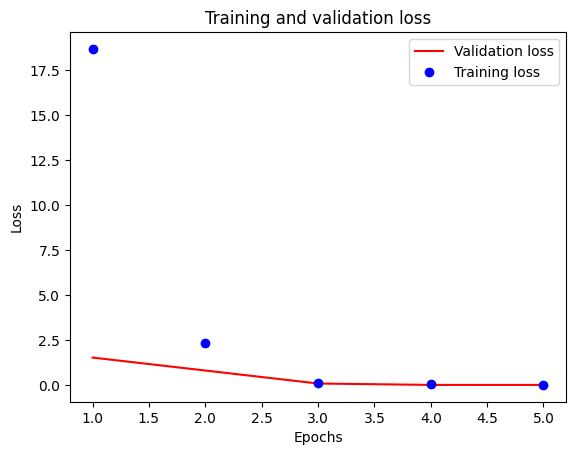

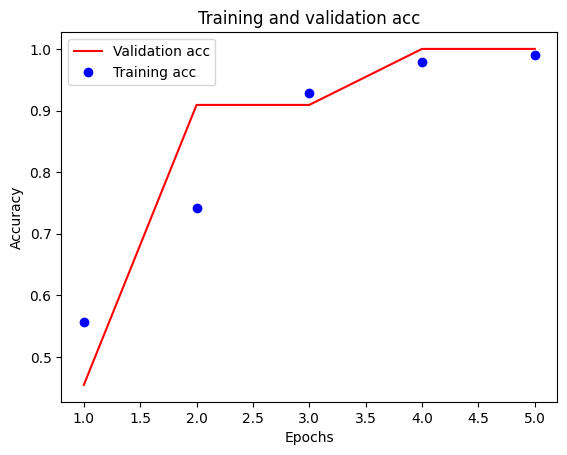

In [4]:
display_optimal_epoch_and_metrics(history)

# Train and validation loss.
plot_learning_metrics(history, title='Training and validation loss', x_label='Epochs', y_label='Loss',
                      metric='loss', line_label='Validation loss', dots_label='Training loss')

# Train and validation accuracy.
plot_learning_metrics(history, title='Training and validation acc', x_label='Epochs', y_label='Accuracy',
                      metric='accuracy', line_label='Validation acc', dots_label='Training acc')

#### Evaluate model with test data

In [5]:
random.shuffle(test_data)

X_test: np.ndarray = np.stack([data.raw_audio for data in test_data])
y_test: np.ndarray = np.stack([data.label for data in test_data])

simple_cnn.evaluate(X_test, y_test)

2/2 [==============================] - 0s 19ms/step - loss: 0.0360 - accuracy: 0.9815


[0.035980481654405594, 0.9814814925193787]

#### Model Architecture

In [6]:
simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram (Sequential)  (None, 40, 128, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 126, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 38304)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 38305     
Total params: 38,625
Trainable params: 38,625
Non-trainable params: 0
_________________________________________________________________
